Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<!-- <p align="center">
  <h1 align="center">TAPIR: Tracking Any Point with per-frame Initialization and temporal Refinement</h1>
  <p align="center">
    <a href="http://www.carldoersch.com/">Carl Doersch</a>
    ·
    <a href="https://yangyi02.github.io/">Yi Yang</a>
    ·
    <a href="https://scholar.google.com/citations?user=Jvi_XPAAAAAJ">Mel Vecerik</a>
    ·
    <a href="https://scholar.google.com/citations?user=cnbENAEAAAAJ">Dilara Gokay</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~ankush/">Ankush Gupta</a>
    ·
    <a href="http://people.csail.mit.edu/yusuf/">Yusuf Aytar</a>
    ·
    <a href="https://scholar.google.co.uk/citations?user=IUZ-7_cAAAAJ">Joao Carreira</a>
    ·
    <a href="https://www.robots.ox.ac.uk/~az/">Andrew Zisserman</a>
  </p>
  <h3 align="center"><a href="https://arxiv.org/abs/2306.08637">Paper</a> | <a href="https://deepmind-tapir.github.io">Project Page</a> | <a href="https://github.com/deepmind/tapnet">GitHub</a> | <a href="https://github.com/deepmind/tapnet/tree/main#running-tapir-locally">Live Demo</a> </h3>
  <div align="center"></div>
</p>

<p align="center">
  <a href="">
    <img src="https://storage.googleapis.com/dm-tapnet/swaying_gif.gif" alt="Logo" width="50%">
  </a>
</p>
 -->


In [1]:
# @title Download Code {form-width: "25%"}
# !git clone https://github.com/deepmind/tapnet.git

In [2]:
# @title Install Dependencies {form-width: "25%"}
# !pip install -r tapnet/requirements_inference.txt

In [3]:
MODEL_TYPE = 'bootstapir' # 'tapir' or 'bootstapir'

In [4]:
# @title Download Model {form-width: "25%"}

# %mkdir tapnet/checkpoints

# if MODEL_TYPE == 'tapir':
#   !wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/tapir_checkpoint_panning.npy
# else:
#   !wget -P tapnet/checkpoints https://storage.googleapis.com/dm-tapnet/bootstapir_checkpoint.npy

# %ls tapnet/checkpoints

In [5]:
# add tapnet to path
import sys
sys.path.append('/home/nrt2124/noah_code/')

In [6]:
%pwd
%cd ../../
%pwd

/home/nrt2124/noah_code


'/home/nrt2124/noah_code'

In [7]:
# @title Imports {form-width: "25%"}
# %matplotlib widget
import functools
import haiku as hk
import jax
import matplotlib.pyplot as plt
import mediapy as media
import numpy as np
import tree

from tapnet import tapir_model
from tapnet.utils import transforms
from tapnet.utils import viz_utils
from tapnet.utils import model_utils

# from google.colab import output
# output.enable_custom_widget_manager()

In [8]:
# @title Load Checkpoint {form-width: "25%"}

if MODEL_TYPE == 'tapir':
  checkpoint_path = 'tapnet/checkpoints/tapir_checkpoint_panning.npy'
else:
  checkpoint_path = 'tapnet/checkpoints/bootstapir_checkpoint.npy'
ckpt_state = np.load(checkpoint_path, allow_pickle=True).item()
params, state = ckpt_state['params'], ckpt_state['state']

In [9]:
# @title Build Model {form-width: "25%"}

def build_model(frames, query_points, model_type='tapir'):
  """Compute point tracks and occlusions given frames and query points."""
  if model_type == 'tapir':
    model = tapir_model.TAPIR(bilinear_interp_with_depthwise_conv=False, pyramid_level=0)
  elif model_type == 'bootstapir':
    model = tapir_model.TAPIR(
        bilinear_interp_with_depthwise_conv=False,
        pyramid_level=1,
        extra_convs=True,
        softmax_temperature=10.0,
    )
  outputs = model(
      video=frames,
      is_training=False,
      query_points=query_points,
      query_chunk_size=64,
  )
  return outputs

build_model_fn = functools.partial(build_model, model_type=MODEL_TYPE)
model = hk.transform_with_state(build_model_fn)
model_apply = jax.jit(model.apply)

In [10]:
# @title Load an Exemplar Video {form-width: "25%"}

# %mkdir tapnet/examplar_videos

# !wget -P tapnet/examplar_videos http://storage.googleapis.com/dm-tapnet/horsejump-high.mp4

# video = media.read_video('tapnet/examplar_videos/horsejump-high.mp4')
video = media.read_video('/home/nrt2124/noah_code/data/output.mp4')
height, width = video.shape[1:3]
media.show_video(video, fps=10)

In [11]:
# @title Utility Functions {form-width: "25%"}

def inference(frames, query_points):
  """Inference on one video.

  Args:
    frames: [num_frames, height, width, 3], [0, 255], np.uint8
    query_points: [num_points, 3], [0, num_frames/height/width], [t, y, x]

  Returns:
    tracks: [num_points, 3], [-1, 1], [t, y, x]
    visibles: [num_points, num_frames], bool
  """
  # Preprocess video to match model inputs format
  frames = model_utils.preprocess_frames(frames)
  num_frames, height, width = frames.shape[0:3]
  query_points = query_points.astype(np.float32)
  frames, query_points = frames[None], query_points[None]  # Add batch dimension

  # Model inference
  rng = jax.random.PRNGKey(42)
  outputs, _ = model_apply(params, state, rng, frames, query_points)
  outputs = tree.map_structure(lambda x: np.array(x[0]), outputs)
  tracks, occlusions, expected_dist = outputs['tracks'], outputs['occlusion'], outputs['expected_dist']

  # Binarize occlusions
  visibles = model_utils.postprocess_occlusions(occlusions, expected_dist)
  return tracks, visibles


def sample_random_points(frame_max_idx, height, width, num_points):
  """Sample random points with (time, height, width) order."""
  y = np.random.randint(0, height, (num_points, 1))
  x = np.random.randint(0, width, (num_points, 1))
  t = np.random.randint(0, frame_max_idx + 1, (num_points, 1))
  points = np.concatenate((t, y, x), axis=-1).astype(np.int32)  # [num_points, 3]
  return points

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], in [x, y]
  Returns:
    query_points: [num_points, 3], in [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

In [12]:
import numpy as np
density_x = 15
density_y = 20
x = np.linspace(90*2, 180*2, density_x)
 
# numpy.linspace creates an array of
# 9 linearly placed elements between
# -4 and 4, both inclusive 
y = np.linspace(40*2, 210*2, density_y)
 
# The meshgrid function returns
# two 2-dimensional arrays 
x1, y1 = np.meshgrid(x, y)
points = [[x, y] for x in x1[0] for y in y1[:,0]]

In [13]:
# @title Predict Sparse Point Tracks {form-width: "25%"}

resize_height = 256*2  # @param {type: "integer"}
resize_width = 256*2  # @param {type: "integer"}
num_points = 20  # @param {type: "integer"}

frames = media.resize_video(video, (resize_height, resize_width))
# query_points = sample_random_points(0, frames.shape[1], frames.shape[2], len(points))
# print(query_points) #list of lists [t, x, y]
query_points = convert_select_points_to_query_points(0, points)
tracks, visibles = inference(frames, query_points)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles)
# media.show_video(video_viz, fps=10)

2024-03-29 12:02:53.458294: W external/xla/xla/service/gpu/nvptx_compiler.cc:744] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-03-29 12:03:56.544356: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[195,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[195,64,256,256]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-03-29 12:03:57.731705: E external/xla/xla/service/slow

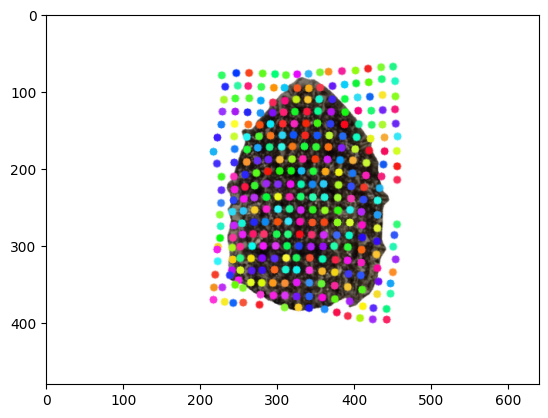

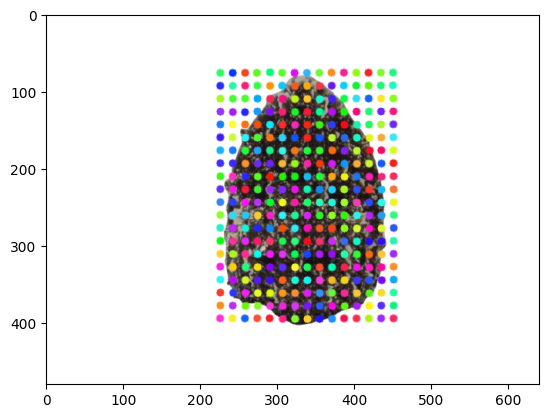

(480, 640, 3)
(480, 640, 3)


In [14]:
plt.imshow(video_viz[180])
plt.show()
# plt.imshow(frames[180])
# plt.show()
plt.imshow(video_viz[0])
plt.show()

print(video_viz[0].shape)
print(video[0].shape)

In [15]:
#extract info from all the points...
print(tracks.shape) #number of points, frames, dimention

#how to do warping?
#how to make points smaller
#how to do more points and more frames...

(300, 195, 2)


In [16]:
import numpy as np
from skimage import transform


<Figure size 640x480 with 0 Axes>

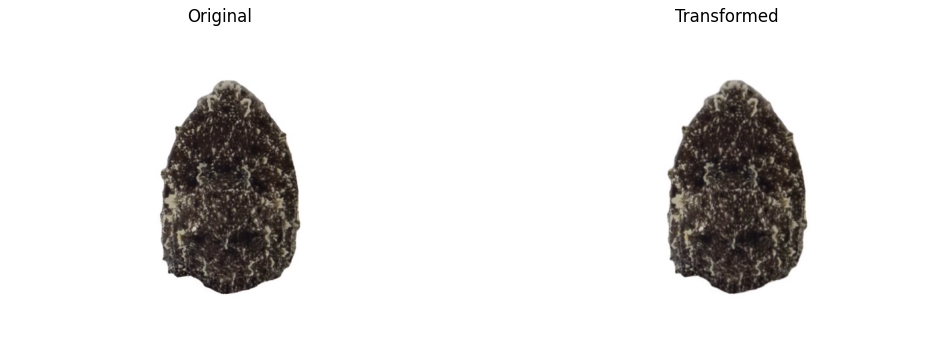

In [34]:
#redo some lost code. Need to make a github too...

reference_index = 0
new_index = 1
reference_points = tracks[:,reference_index,:]
new_points = tracks[:,new_index,:]

reference_frame = video[reference_index] #DONT use frames, use video...
new_frame = video[new_index]

tform = transform.estimate_transform('euclidean', new_points, reference_points)
tf_img_warp = transform.warp(new_frame, tform.inverse, mode = 'symmetric')


plt.figure(num=None, figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(1,2, figsize=(15, 10), dpi = 80)
ax[0].set_title(f'Original', fontsize = 15)
ax[0].imshow(new_frame)
ax[0].set_axis_off()
ax[1].set_title(f'Transformed', fontsize = 15)
ax[1].imshow(tf_img_warp)
ax[1].set_axis_off()
plt.show()

In [48]:
new_frame.dtype
#another typing issue!! need to convert this to uint8 again...

dtype('uint8')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

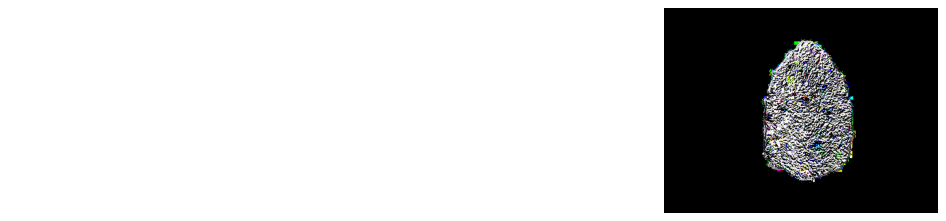

In [46]:

plt.figure(num=None, figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(1,3, figsize=(15, 10), dpi = 80)
ax[0].imshow(new_frame - tf_img_warp)
ax[0].set_axis_off()
ax[1].imshow(reference_frame - tf_img_warp)
ax[1].set_axis_off()
ax[2].imshow(reference_frame - new_frame)
ax[2].set_axis_off()

In [18]:
def dewarp_video(tracks, video, reference_frame, method='projective'):

    """
    Method is usually projective, euclidean, or affine... (or anything else sklearn can do)
    """

    reference_points = tracks[:,reference_frame, :]

    dewarped_frames = []
    for i, frame in enumerate(video):
        frame_points = tracks[:,i, :]
        dewarper = transform.estimate_transform(method, frame_points, reference_points)
        dewarped_frame = transform.warp(frame, dewarper.inverse, mode = 'symmetric')
        dewarped_frames.append(dewarped_frame)
    
    return dewarped_frames

dewarped_video = np.asarray(dewarp_video(tracks, video, 0))


        

In [19]:
dewarped_video.shape

(195, 480, 640, 3)

In [20]:
#evaluate motion correction...
#average frames and look at sharpness, or fft phase correlations between frames

def motion_eval(video):
    gray_video = np.mean(video, axis = 3)
    avg_frame = np.mean(gray_video, axis = 0)
    gy, gx = np.gradient(avg_frame)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

print(motion_eval(dewarped_video))
print(motion_eval(np.asarray(video)))

0.006347681218987637
1.0664423741226166


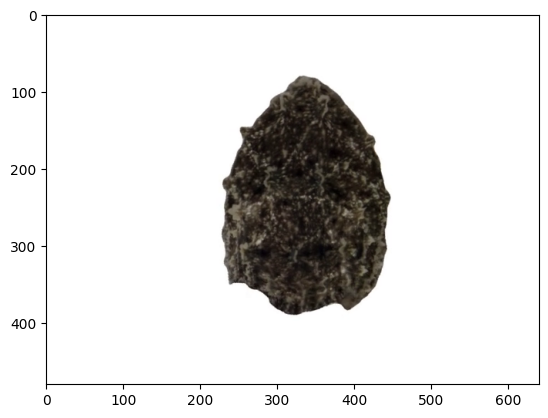

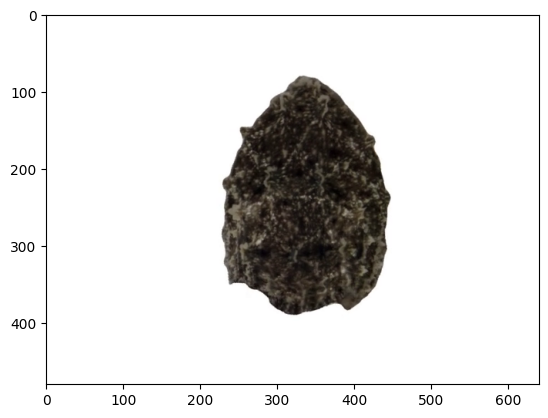

2.1082886963614276


In [64]:
#test

no_motion_data = np.empty_like(np.asarray(video))
for i in range(no_motion_data.shape[0]):
    no_motion_data[i] = (np.asarray(video[90]))

plt.imshow(no_motion_data[53])
plt.show()
plt.imshow(no_motion_data[1])
plt.show()

print(motion_eval(no_motion_data))


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

# Example: Creating a dummy set of images (replace with your actual images)
# # Let's assume each image is 256x256 pixels and we have 10 images
# images = dewarped_video

# # Setting up the figure and axis for the animation
# fig, ax = plt.subplots()
# ax.axis('off')
# # Initializing the first frame. Here, 'im' will be updated in the animation
# im = ax.imshow(images[0], cmap='gray')

# def update(frame):
#     """Updates the image displayed by matplotlib."""
#     im.set_data(images[frame])
#     return [im]

# # Creating the animation
# ani = FuncAnimation(fig, update, frames=range(len(images)), blit=True)

# # Save the animation
# ani.save('/home/nrt2124/noah_code/data/dewarped.mp4', writer='ffmpeg', fps=5)

# plt.close()  # Close the figure to prevent it from displaying in the notebook

In [30]:
video2 = dewarped_video
print(video2.shape)
print(video.shape)

(195, 480, 640, 3)
(195, 480, 640, 3)


In [31]:
# retrack the dewarped video

# video2 = media.read_video('/home/nrt2124/noah_code/data/output.mp4')
# height2, width2 = video2.shape[1:3]


resize_height = 256*2  # @param {type: "integer"}
resize_width = 256*2  # @param {type: "integer"}
num_points = 20  # @param {type: "integer"}

frames = media.resize_video(dewarped_video, (resize_height, resize_width))
# query_points = sample_random_points(0, frames.shape[1], frames.shape[2], len(points))
# print(query_points) #list of lists [t, x, y]
query_points = convert_select_points_to_query_points(0, points)
tracks2, visibles2 = inference(frames, query_points)

# Visualize sparse point tracks
tracks2 = transforms.convert_grid_coordinates(tracks2, (resize_width, resize_height), (width, height))
video_viz2 = viz_utils.paint_point_track(dewarped_video, tracks2, visibles2)
# media.show_video(video_viz, fps=10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


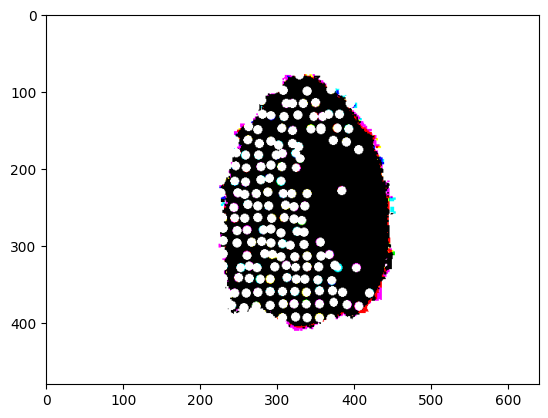

In [32]:
plt.imshow(video_viz2[50])

In [ ]:
# @title Select Any Points at Any Frame {form-width: "25%"}

select_frame = 0  #@param {type:"slider", min:0, max:49, step:1}

# Generate a colormap with 20 points, no need to change unless select more than 20 points
colormap = viz_utils.get_colors(20)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(video[select_frame])
ax.axis('off')
ax.set_title('You can select more than 1 point. After selecting enough points, run the next cell.')

select_points = []

 # Event handler for mouse clicks
def on_click(event):
  if event.button == 1 and event.inaxes == ax:  # Left mouse button clicked
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))

    select_points.append(np.array([x, y]))

    color = colormap[len(select_points) - 1]
    color = tuple(np.array(color) / 255.0)
    ax.plot(x, y, 'o', color=color, markersize=5)
    plt.draw()

fig.canvas.mpl_connect('button_press_event', on_click)
plt.show()

In [ ]:
# @title Predict Point Tracks for the Selected Points {form-width: "25%"}

resize_height = 256  # @param {type: "integer"}
resize_width = 256  # @param {type: "integer"}

def convert_select_points_to_query_points(frame, points):
  """Convert select points to query points.

  Args:
    points: [num_points, 2], in [x, y]
  Returns:
    query_points: [num_points, 3], in [t, y, x]
  """
  points = np.stack(points)
  query_points = np.zeros(shape=(points.shape[0], 3), dtype=np.float32)
  query_points[:, 0] = frame
  query_points[:, 1] = points[:, 1]
  query_points[:, 2] = points[:, 0]
  return query_points

frames = media.resize_video(video, (resize_height, resize_width))
query_points = convert_select_points_to_query_points(select_frame, select_points)
query_points = transforms.convert_grid_coordinates(
    query_points, (1, height, width), (1, resize_height, resize_width), coordinate_format='tyx')
tracks, visibles = inference(frames, query_points)

# Visualize sparse point tracks
tracks = transforms.convert_grid_coordinates(tracks, (resize_width, resize_height), (width, height))
video_viz = viz_utils.paint_point_track(video, tracks, visibles, colormap)
media.show_video(video_viz, fps=10)

That's it!